In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/cleaned_global_water_consumption.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("Analyse de la consommation mondiale d'eau") \
    .getOrCreate()

# Création du contexte Spark
sc = spark.sparkContext

## Partie 1 : Manipulation des RDD

1. Charger le fichier CSV en RDD et supprimer l'en-tête


In [ ]:
rdd_raw = sc.textFile(dataset_path)
header = rdd_raw.first()
rdd_data = rdd_raw.filter(lambda line: line != header)

2. Transformer les données pour les rendre exploitables


In [ ]:
def parse_line(line):
    # Utilisation de split avec virgule comme délimiteur
    parts = line.split(',')

    try:
        country = parts[0].strip()
        year = int(parts[1].strip())
        total_consumption = float(parts[2].strip())
        per_capita = float(parts[3].strip())
        agricultural_use = float(parts[4].strip())
        industrial_use = float(parts[5].strip())
        household_use = float(parts[6].strip())
        rainfall = float(parts[7].strip())
        ground_water_depletion = float(parts[8].strip() if len(parts) > 8 else 0.0)

        return (country, year, total_consumption, per_capita,
                agricultural_use, industrial_use, household_use,
                rainfall, ground_water_depletion)
    except ValueError:
        # En cas d'erreur de conversion
        return None

# Application de la transformation map
rdd_parsed = rdd_data.map(parse_line).filter(lambda x: x is not None)

In [ ]:
rdd_parsed.take(3)

[('Argentina',
  2000,
  481.49,
  235.4314286,
  48.55,
  20.84428571,
  30.1,
  1288.698571,
  3.255714286),
 ('Argentina', 2001, 455.063, 299.551, 48.465, 26.943, 22.55, 1371.729, 3.12),
 ('Argentina',
  2002,
  482.7492308,
  340.1246154,
  50.37538462,
  29.04230769,
  23.34923077,
  1590.305385,
  2.733846154)]

#### Visualisation complete du dataset

In [ ]:
spark_df = spark.createDataFrame(rdd_parsed, schema=['country', 'year', 'total_consumption', 'per_capita',
                'agricultural_use', 'industrial_use', 'household_use',
                'rainfall', 'ground_water_depletion'])

spark_df.show()

+---------+----+-----------------+-----------+----------------+--------------+-------------+-----------+----------------------+
|  country|year|total_consumption| per_capita|agricultural_use|industrial_use|household_use|   rainfall|ground_water_depletion|
+---------+----+-----------------+-----------+----------------+--------------+-------------+-----------+----------------------+
|Argentina|2000|           481.49|235.4314286|           48.55|   20.84428571|         30.1|1288.698571|           3.255714286|
|Argentina|2001|          455.063|    299.551|          48.465|        26.943|        22.55|   1371.729|                  3.12|
|Argentina|2002|      482.7492308|340.1246154|     50.37538462|   29.04230769|  23.34923077|1590.305385|           2.733846154|
|Argentina|2003|           452.66|326.7566667|     49.08666667|        30.476|        24.44|1816.012667|                 2.708|
|Argentina|2004|          634.566|    230.346|           38.67|         36.67|       23.924|    815.998|

3. Appliquer les transformations suivantes
- filter : Supprimer les valeurs **nulles** et **aberrantes**

In [ ]:
# Supposons que les valeurs négatives sont aberrantes
rdd_filtered = rdd_parsed.filter(lambda x:
    x[2] > 0 and x[3] > 0 and x[4] >= 0 and
    x[5] >= 0 and x[6] >= 0 and x[7] >= 0 and x[8] >= 0)

In [ ]:
# # Supposons que les valeurs aberrantes : Méthode basée sur l'écart-type
def detect_outliers_stddev(rdd, column_index, std_threshold=3.0):
    # Extraire la colonne spécifique pour le calcul
    column_values = rdd.map(lambda x: x[column_index])

    # Calculer les statistiques
    count = column_values.count()
    column_sum = column_values.sum()
    mean = column_sum / count

    # Calculer l'écart-type
    variance = column_values.map(lambda x: (x - mean) ** 2).sum() / count
    std_dev = variance ** 0.5

    # Définir les limites
    lower_bound = mean - std_threshold * std_dev
    upper_bound = mean + std_threshold * std_dev

    # Filtrer le RDD original
    return rdd.filter(lambda x: lower_bound <= x[column_index] <= upper_bound)

# for i in range(2,7):
#   detect_outliers_stddev(rdd_filtered, i).take(3)

##### There are no outliers in the dataset

In [ ]:
# df = rdd_filtered.toDF()
# df.describe().show()

- reduce : Calculer la consommation totale d'eau par pays.
- sortByKey : Trier les pays par ordre alphabétique.

In [ ]:
# map : Préparer les données pour la réduction (0:pays, 2:consommation totale)
rdd_country_consumption = rdd_filtered.map(lambda x: (x[0], x[2]))

# reduce : Calculer la consommation totale d'eau par pays
rdd_total_by_country = rdd_country_consumption.reduceByKey(lambda a, b: a + b)

# sortByKey : Trier les pays par ordre alphabétique
rdd_sorted = rdd_total_by_country.sortByKey()

In [ ]:
# Afficher les résultats
print("Consommation totale d'eau par pays (ordre alphabétique):")
for country, total in rdd_sorted.collect():
    print(f"{country}: {total:.2f}    milliards de mètres cubes")

Consommation totale d'eau par pays (ordre alphabétique):
Argentina: 13284.86    milliards de mètres cubes
Australia: 12505.78    milliards de mètres cubes
Brazil: 13263.29    milliards de mètres cubes
Canada: 12352.69    milliards de mètres cubes
China: 13133.60    milliards de mètres cubes
France: 12596.12    milliards de mètres cubes
Germany: 12668.59    milliards de mètres cubes
India: 12581.66    milliards de mètres cubes
Indonesia: 12151.27    milliards de mètres cubes
Italy: 12449.63    milliards de mètres cubes
Japan: 12585.68    milliards de mètres cubes
Mexico: 12058.05    milliards de mètres cubes
Russia: 12385.53    milliards de mètres cubes
Saudi Arabia: 12966.08    milliards de mètres cubes
South Africa: 12544.93    milliards de mètres cubes
South Korea: 12184.87    milliards de mètres cubes
Spain: 11796.58    milliards de mètres cubes
Turkey: 11882.58    milliards de mètres cubes
UK: 12161.47    milliards de mètres cubes
USA: 13058.95    milliards de mètres cubes


#### EXTRA

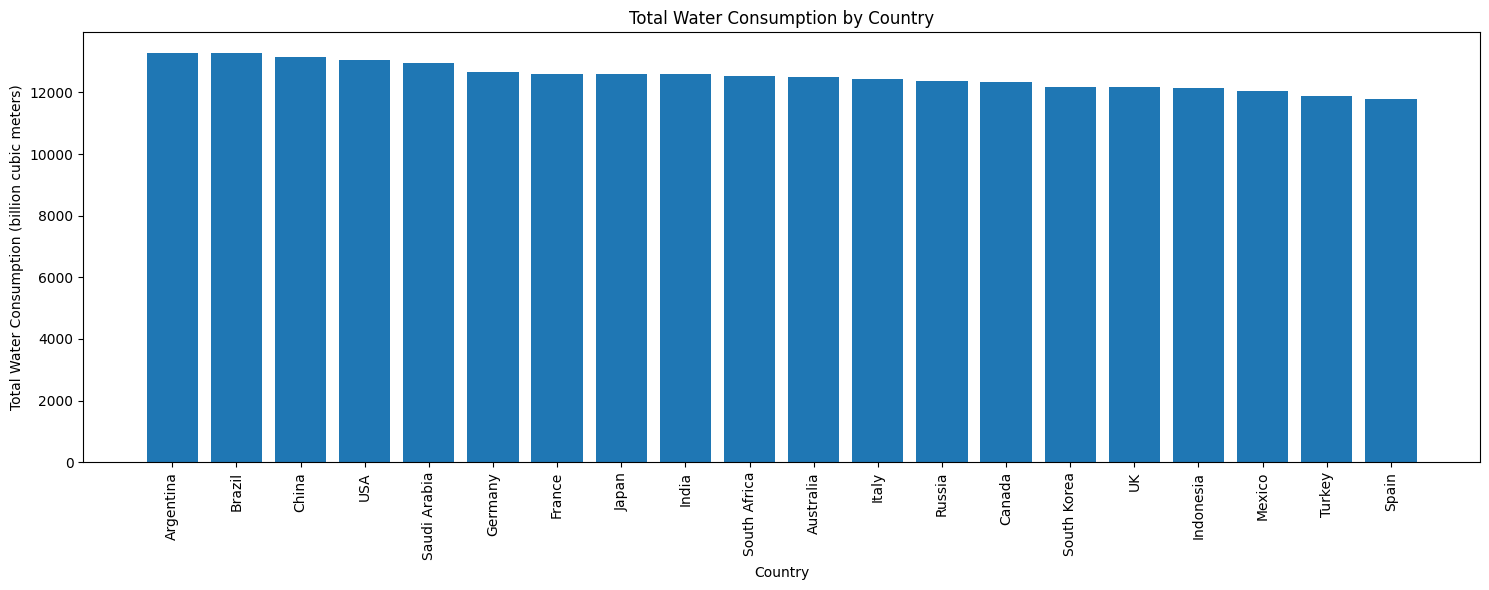

In [ ]:
# Convert the RDD to a Pandas DataFrame for easier plotting
rdd_sorted_list = rdd_sorted.collect()
df_sorted = pd.DataFrame(rdd_sorted_list, columns=['Country', 'Total Consumption'])

# Sort the DataFrame by total consumption in descending order
df_sorted = df_sorted.sort_values('Total Consumption', ascending=False)

# Create the bar plot
plt.figure(figsize=(15, 6))  # Adjust figure size for better readability
plt.bar(df_sorted['Country'], df_sorted['Total Consumption'])
plt.xlabel("Country")
plt.ylabel("Total Water Consumption (billion cubic meters)")
plt.title("Total Water Consumption by Country")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
# Tendance de consommation d'eau par année
rdd_year_consumption = rdd_filtered.map(lambda x: (x[1], (x[2], 1)))
rdd_avg_year = rdd_year_consumption.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
rdd_avg_year = rdd_avg_year.mapValues(lambda x: x[0] / x[1])
rdd_avg_year_sorted = rdd_avg_year.sortByKey()

print("\nConsommation moyenne d'eau par année:")
for year, avg in rdd_avg_year_sorted.collect():
    print(f"{year}: {avg:.2f} milliards de mètres cubes")


Consommation moyenne d'eau par année:
2000: 504.52 milliards de mètres cubes
2001: 503.05 milliards de mètres cubes
2002: 474.91 milliards de mètres cubes
2003: 509.34 milliards de mètres cubes
2004: 545.10 milliards de mètres cubes
2005: 456.24 milliards de mètres cubes
2006: 492.63 milliards de mètres cubes
2007: 517.57 milliards de mètres cubes
2008: 553.14 milliards de mètres cubes
2009: 469.90 milliards de mètres cubes
2010: 491.26 milliards de mètres cubes
2011: 524.95 milliards de mètres cubes
2012: 534.07 milliards de mètres cubes
2013: 482.94 milliards de mètres cubes
2014: 507.67 milliards de mètres cubes
2015: 490.59 milliards de mètres cubes
2016: 499.86 milliards de mètres cubes
2017: 518.53 milliards de mètres cubes
2018: 522.16 milliards de mètres cubes
2019: 494.95 milliards de mètres cubes
2020: 473.47 milliards de mètres cubes
2021: 480.45 milliards de mètres cubes
2022: 502.22 milliards de mètres cubes
2023: 481.36 milliards de mètres cubes
2024: 499.73 milliards de

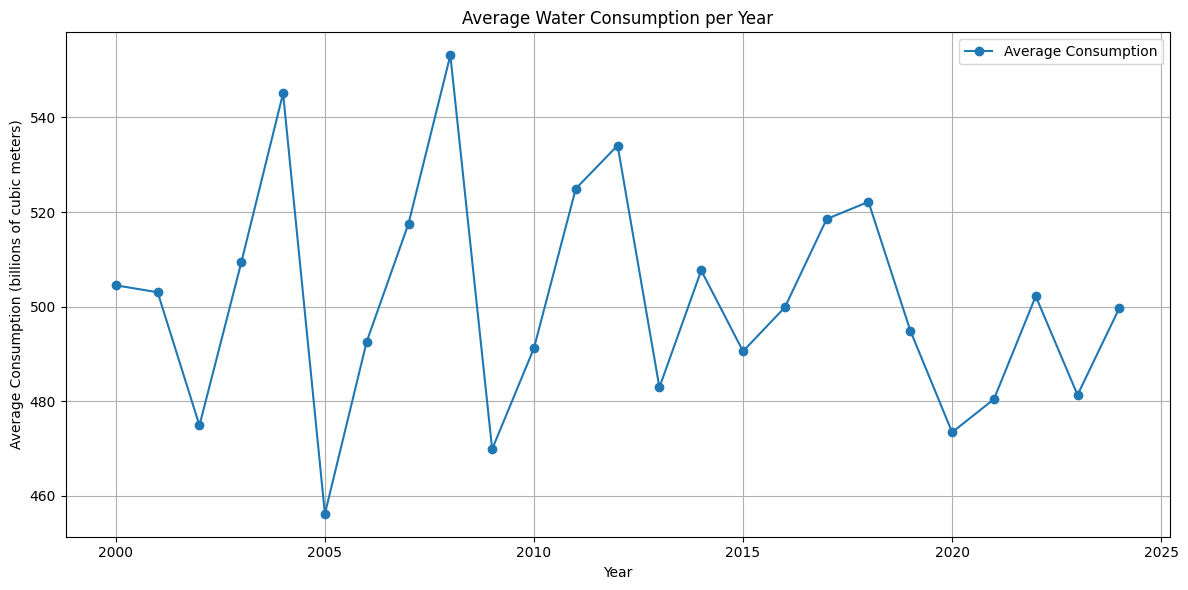

In [ ]:
# prompt: generer une plot pour la Consommation moyenne d'eau par année

import matplotlib.pyplot as plt
# Convert the RDD to a Pandas DataFrame for easier plotting
df_avg_year = rdd_avg_year_sorted.toDF(["year", "avg_consumption"]).toPandas()

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(df_avg_year["year"], df_avg_year["avg_consumption"], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average Consumption (billions of cubic meters)")
plt.title("Average Water Consumption per Year")
plt.grid(True)
plt.legend(['Average Consumption'])
plt.tight_layout()
plt.show()


# Partie 2: Utilisation de Spark SQL

In [ ]:
from pyspark.sql.functions import col, stddev, avg, min, max, year, count, desc, sum, abs, variance
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Définir le schéma pour plus de clarté
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

4. Convertir l'ensemble de données en DataFrame Spark et créer une vue temporaire

In [ ]:
# Définir le schéma
schema = StructType([
    StructField("Country", StringType(), False),
    StructField("Year", IntegerType(), False),
    StructField("TotalConsumption", FloatType(), False),
    StructField("PerCapitaConsumption", FloatType(), False),
    StructField("AgriculturalUsePercent", FloatType(), False),
    StructField("IndustrialUsePercent", FloatType(), False),
    StructField("HouseholdUsePercent", FloatType(), False),
    StructField("Rainfall", FloatType(), False),
    StructField("DepletionRate", FloatType(), False)
])

# Convertir RDD en DataFrame avec le schéma
df_water = spark.createDataFrame(rdd_filtered, schema)

In [ ]:
df_water.show(5)

+---------+----+----------------+--------------------+----------------------+--------------------+-------------------+---------+-------------+
|  Country|Year|TotalConsumption|PerCapitaConsumption|AgriculturalUsePercent|IndustrialUsePercent|HouseholdUsePercent| Rainfall|DepletionRate|
+---------+----+----------------+--------------------+----------------------+--------------------+-------------------+---------+-------------+
|Argentina|2000|          481.49|           235.43143|                 48.55|           20.844286|               30.1|1288.6986|    3.2557142|
|Argentina|2001|         455.063|             299.551|                48.465|              26.943|              22.55| 1371.729|         3.12|
|Argentina|2002|       482.74924|            340.1246|             50.375385|           29.042307|          23.349232|1590.3054|    2.7338462|
|Argentina|2003|          452.66|           326.75665|             49.086666|              30.476|              24.44|1816.0127|        2.708|

In [ ]:
# Créer une vue temporaire pour les requêtes SQL
df_water.createOrReplaceTempView("water_consumption")

5. Exécuter les requêtes SQL
- Identifier les pays avec la consommation d’eau la plus stable au fil des années.


In [ ]:
stability_query = """
SELECT
    Country,
    COUNT(*) as YearsOfData,
    AVG(TotalConsumption) as AvgConsumption,
    VARIANCE(TotalConsumption) as ConsumptionVariance,
    VARIANCE(TotalConsumption) / AVG(TotalConsumption) as CoefficientOfVariation
FROM
    water_consumption
GROUP BY
    Country
HAVING
    COUNT(*) >= 5  -- Filtrer les pays avec au moins 5 années de données
ORDER BY
    CoefficientOfVariation ASC
LIMIT 10
"""

stability_results = spark.sql(stability_query)
stability_results.show()

+------------+-----------+------------------+-------------------+----------------------+
|     Country|YearsOfData|    AvgConsumption|ConsumptionVariance|CoefficientOfVariation|
+------------+-----------+------------------+-------------------+----------------------+
|   Argentina|         25| 531.3944287109375|   5458.13314656633|    10.271340555464102|
|Saudi Arabia|         25| 518.6431469726563|  5771.639129567495|     11.12834356967178|
|      Mexico|         25| 482.3221691894531|  5436.816722805665|    11.272168417931704|
|South Africa|         25|  501.797236328125|  5891.786049389256|    11.741368072295678|
|      Russia|         25| 495.4210632324219| 6243.5507282913495|    12.602513683117767|
|       Spain|         25| 471.8631652832031|  6945.233204605291|    14.718744152103707|
|       India|         25| 503.2665100097656|  7878.339492193659|     15.65440842078044|
|      France|         25| 503.8446301269531|  8282.527537873071|    16.438653987016064|
| South Korea|       

- Étudier les tendances de consommation d'eau dans les régions arides

In [ ]:
# Identifier les régions arides (précipitations faibles)
arid_regions_query = """
SELECT
    Country,
    AVG(Rainfall) as AvgRainfall,
    AVG(TotalConsumption) as AvgConsumption,
    AVG(DepletionRate) as AvgDepletionRate
FROM
    water_consumption
GROUP BY
    Country
ORDER BY
    AvgRainfall ASC
LIMIT 5
"""

arid_regions_results = spark.sql(arid_regions_query)
arid_regions_results.show()

+------------+------------------+------------------+------------------+
|     Country|       AvgRainfall|    AvgConsumption|  AvgDepletionRate|
+------------+------------------+------------------+------------------+
|Saudi Arabia|1444.4051147460937| 518.6431469726563| 2.502806406021118|
| South Korea|  1444.83755859375|487.39469848632814|2.5670709085464476|
|   Australia|1475.0312353515626| 500.2311309814453|2.5900704526901244|
|South Africa|1488.5815771484374|  501.797236328125|2.5481668186187743|
|      Mexico|1492.9619213867188| 482.3221691894531|2.7989727687835693|
+------------+------------------+------------------+------------------+



In [ ]:
# Analyser les tendances dans ces régions arides
arid_trends_query = """
WITH AridCountries AS (
  SELECT
    Country,
    AVG(Rainfall) as AvgRainfall
  FROM
    water_consumption
  GROUP BY
    Country
  ORDER BY
    AvgRainfall ASC
  LIMIT 5
)

SELECT
    w.Country,
    w.Year,
    w.TotalConsumption,
    w.PerCapitaConsumption,
    w.AgriculturalUsePercent,
    w.DepletionRate
FROM
    water_consumption w
JOIN
    AridCountries ac ON w.Country = ac.Country
ORDER BY
    w.Country, w.Year
"""

arid_trends_results = spark.sql(arid_trends_query)
arid_trends_results.show()

+---------+----+----------------+--------------------+----------------------+-------------+
|  Country|Year|TotalConsumption|PerCapitaConsumption|AgriculturalUsePercent|DepletionRate|
+---------+----+----------------+--------------------+----------------------+-------------+
|Australia|2000|          545.04|              296.13|              54.66375|      2.36625|
|Australia|2001|         448.229|             247.556|                46.922|        2.698|
|Australia|2002|       488.00333|           236.69667|             58.886665|    2.2066667|
|Australia|2003|          540.81|           275.34167|               48.9825|    3.3241668|
|Australia|2004|       503.86642|           261.01572|              51.07143|    2.2142856|
|Australia|2005|          503.61|           255.90454|             53.115456|    2.2527273|
|Australia|2006|        438.3757|           279.74786|              48.02643|    2.2828572|
|Australia|2007|       376.92374|           228.62125|              53.56125|   

3. Analyser les pics de consommation d'eau et proposer des explications
- valeurs supérieures à 1.4 fois la moyenne du pays

In [ ]:
consumption_peaks_query = """
WITH CountryAvgs AS (
    SELECT
        Country,
        AVG(TotalConsumption) as AvgConsumption
    FROM
        water_consumption
    GROUP BY
        Country
)

SELECT
    w.Country,
    w.Year,
    w.TotalConsumption,
    w.PerCapitaConsumption,
    w.Rainfall,
    ca.AvgConsumption,
    w.TotalConsumption / ca.AvgConsumption as ConsumptionRatio
FROM
    water_consumption w
JOIN
    CountryAvgs ca ON w.Country = ca.Country
WHERE
    w.TotalConsumption > ca.AvgConsumption * 1.4
ORDER BY
    ConsumptionRatio DESC
"""

consumption_peaks_results = spark.sql(consumption_peaks_query)
consumption_peaks_results.show()

+---------+----+----------------+--------------------+---------+------------------+------------------+
|  Country|Year|TotalConsumption|PerCapitaConsumption| Rainfall|    AvgConsumption|  ConsumptionRatio|
+---------+----+----------------+--------------------+---------+------------------+------------------+
|    China|2004|         798.418|             332.616| 1494.778| 525.3438720703125|1.5198007861759073|
|   Canada|2006|       748.42334|           319.71667|1202.8267|494.10778564453125|1.5146965127608356|
|Indonesia|2017|       719.68286|           255.63571|1321.2957| 486.0507019042969|  1.48067446154996|
|   Brazil|2006|       781.34283|              236.87|1818.1357|  530.531494140625| 1.472754856407356|
|  Germany|2003|         727.987|             289.484| 1384.207|506.74354675292966| 1.436598461246236|
|      USA|2009|        743.6711|            291.4511|1732.9911| 522.3580340576171|1.4236807573652448|
|    India|2011|        715.1671|            269.5357|1213.1614| 503.2665

4. Comparer la consommation d'eau entre pays développés et en développement

In [ ]:
# Liste simplifiée de pays développés (pour démonstration - à compléter)
developed_countries = ["USA", "Canada", "Japan", "France", "Germany", "UK",
                      "Italy", "Australia","Spain","South Korea"]

# Créer un DataFrame avec une colonne indiquant si le pays est développé ou en développement
country_status_df = spark.createDataFrame([(country, "Developed") if country in developed_countries
                                          else (country, "Developing")
                                          for country in df_water.select("Country").distinct().rdd.flatMap(lambda x: x).collect()],
                                         ["Country", "DevelopmentStatus"])

# Créer une vue temporaire pour ce DataFrame
country_status_df.createOrReplaceTempView("country_status")

In [ ]:
# Comparer les métriques entre les deux groupes
development_comparison_query = """
SELECT
    cs.DevelopmentStatus,
    AVG(w.TotalConsumption) as AvgTotalConsumption,
    AVG(w.PerCapitaConsumption) as AvgPerCapitaConsumption,
    AVG(w.AgriculturalUsePercent) as AvgAgriculturalUse,
    AVG(w.IndustrialUsePercent) as AvgIndustrialUse,
    AVG(w.HouseholdUsePercent) as AvgHouseholdUse,
    AVG(w.DepletionRate) as AvgDepletionRate
FROM
    water_consumption w
JOIN
    country_status cs ON w.Country = cs.Country
GROUP BY
    cs.DevelopmentStatus
"""

development_comparison_results = spark.sql(development_comparison_query)
development_comparison_results.show()

+-----------------+-------------------+-----------------------+------------------+------------------+------------------+------------------+
|DevelopmentStatus|AvgTotalConsumption|AvgPerCapitaConsumption|AvgAgriculturalUse|  AvgIndustrialUse|   AvgHouseholdUse|  AvgDepletionRate|
+-----------------+-------------------+-----------------------+------------------+------------------+------------------+------------------+
|        Developed| 497.44145739746097|     274.55079067993165|  49.9699077835083|27.747444877624513|24.952436019897462|2.5803606634140013|
|       Developing| 505.00740185546874|      277.4587734069824|  50.3917511138916|27.838229751586915| 24.71259454345703| 2.565713529586792|
+-----------------+-------------------+-----------------------+------------------+------------------+------------------+------------------+



In [ ]:
# Tendances au fil du temps par statut de développement
development_trends_query = """
SELECT
    cs.DevelopmentStatus,
    w.Year,
    AVG(w.TotalConsumption) as AvgTotalConsumption,
    AVG(w.PerCapitaConsumption) as AvgPerCapitaConsumption
FROM
    water_consumption w
JOIN
    country_status cs ON w.Country = cs.Country
GROUP BY
    cs.DevelopmentStatus, w.Year
ORDER BY
    cs.DevelopmentStatus, w.Year
"""

development_trends_results = spark.sql(development_trends_query)
development_trends_results.show()

+-----------------+----+-------------------+-----------------------+
|DevelopmentStatus|Year|AvgTotalConsumption|AvgPerCapitaConsumption|
+-----------------+----+-------------------+-----------------------+
|        Developed|2000|  472.2390411376953|     285.99994506835935|
|        Developed|2001|  498.1623992919922|     284.21413269042966|
|        Developed|2002|  535.9186218261718|     270.43670043945315|
|        Developed|2003|  536.1644500732422|     276.41650238037107|
|        Developed|2004|  512.3101348876953|      280.0647514343262|
|        Developed|2005|  454.5521728515625|     282.69749450683594|
|        Developed|2006|  492.5998138427734|      286.9174041748047|
|        Developed|2007|  505.1031127929688|     265.20169830322266|
|        Developed|2008|  536.3177032470703|      277.1590286254883|
|        Developed|2009|  436.9114395141602|      259.7168960571289|
|        Developed|2010|  512.9920776367187|      255.3793960571289|
|        Developed|2011|  518.5659

5. Déterminer si les politiques de conservation de l'eau ont eu un impact significatif sur la consommation totale

In [ ]:
# Nous pouvons supposer que les politiques de conservation sont généralement mises en place après 2006
# Comparer les tendances avant et après cette date
conservation_impact_query = """
SELECT
    CASE
        WHEN Year < 2006 THEN 'Pre-Conservation'
        ELSE 'Post-Conservation'
    END as Period,
    AVG(TotalConsumption) as AvgConsumption,
    AVG(PerCapitaConsumption) as AvgPerCapita,
    AVG(DepletionRate) as AvgDepletionRate
FROM
    water_consumption
GROUP BY
    CASE
        WHEN Year < 2006 THEN 'Pre-Conservation'
        ELSE 'Post-Conservation'
    END
"""

conservation_impact_results = spark.sql(conservation_impact_query)
conservation_impact_results.show()

+-----------------+------------------+------------------+------------------+
|           Period|    AvgConsumption|      AvgPerCapita|  AvgDepletionRate|
+-----------------+------------------+------------------+------------------+
|Post-Conservation|501.97127745778937|276.13100519682234| 2.567721538794668|
| Pre-Conservation|498.85941149393716|275.60507539113365|2.5898696959018705|
+-----------------+------------------+------------------+------------------+



In [ ]:
# Analyser les tendances annuelles pour voir l'évolution
conservation_trends_query = """
SELECT
    Year,
    AVG(TotalConsumption) as AvgConsumption,
    AVG(PerCapitaConsumption) as AvgPerCapita,
    AVG(DepletionRate) as AvgDepletionRate
FROM
    water_consumption
GROUP BY
    Year
ORDER BY
    Year
"""

conservation_trends_results = spark.sql(conservation_trends_query)
conservation_trends_results.show()

+----+------------------+------------------+------------------+
|Year|    AvgConsumption|      AvgPerCapita|  AvgDepletionRate|
+----+------------------+------------------+------------------+
|2000| 504.5190963745117|282.10889739990233| 2.658793693780899|
|2001|503.05359954833983|266.25109710693357| 2.614680314064026|
|2002|  474.905744934082|276.13790969848634|2.4591799676418304|
|2003|509.34378814697266|281.65490951538084|2.7009953260421753|
|2004| 545.0963134765625|281.95437507629396| 2.509175157546997|
|2005| 456.2379264831543| 265.5232635498047| 2.596393716335297|
|2006|492.62905197143556| 278.9496982574463|2.6880770564079284|
|2007|  517.571794128418| 269.7141716003418|2.5935851633548737|
|2008| 553.1387924194336|268.98168563842773| 2.663728839159012|
|2009|469.89905014038084| 262.9822723388672|2.5582258224487306|
|2010|491.25575561523436|265.79106216430665|2.3804350674152372|
|2011| 524.9529190063477|276.10350494384767| 2.576512748003006|
|2012|  534.068244934082| 277.1756080627

In [ ]:
# Analyser les pays individuels pour identifier ceux qui ont réalisé des améliorations significatives
country_improvements_query = """
WITH PreConservation AS (
    SELECT
        Country,
        AVG(TotalConsumption) as AvgConsumptionPre,
        AVG(PerCapitaConsumption) as AvgPerCapitaPre
    FROM
        water_consumption
    WHERE
        Year < 2006
    GROUP BY
        Country
),
PostConservation AS (
    SELECT
        Country,
        AVG(TotalConsumption) as AvgConsumptionPost,
        AVG(PerCapitaConsumption) as AvgPerCapitaPost
    FROM
        water_consumption
    WHERE
        Year >= 2006
    GROUP BY
        Country
)

SELECT
    pre.Country,
    pre.AvgConsumptionPre,
    post.AvgConsumptionPost,
    (post.AvgConsumptionPost - pre.AvgConsumptionPre) / pre.AvgConsumptionPre * 100 as ConsumptionChangePercent,
    pre.AvgPerCapitaPre,
    post.AvgPerCapitaPost,
    (post.AvgPerCapitaPost - pre.AvgPerCapitaPre) / pre.AvgPerCapitaPre * 100 as PerCapitaChangePercent
FROM
    PreConservation pre
JOIN
    PostConservation post ON pre.Country = post.Country
ORDER BY
    PerCapitaChangePercent ASC
"""

country_improvements_results = spark.sql(country_improvements_query)
country_improvements_results.show()


+------------+------------------+------------------+------------------------+------------------+------------------+----------------------+
|     Country| AvgConsumptionPre|AvgConsumptionPost|ConsumptionChangePercent|   AvgPerCapitaPre|  AvgPerCapitaPost|PerCapitaChangePercent|
+------------+------------------+------------------+------------------------+------------------+------------------+----------------------+
|          UK|473.86944580078125|490.43463937859786|      3.4957294091463247| 313.3763071695964|270.77385269968136|   -13.594663506855023|
|      France| 529.1623280843099| 495.8495676141036|      -6.295376428402649|  290.320317586263|  268.909035130551|    -7.375054778710094|
|      Canada| 416.3301747639974| 518.6691364489103|       24.58120210549841| 282.7191899617513|  262.434550235146|    -7.174836532797641|
|       Spain|495.82347106933594| 464.2967529296875|      -6.358456180312558| 286.8641662597656| 267.6260737368935|    -6.706342159672659|
|   Argentina| 494.10086568

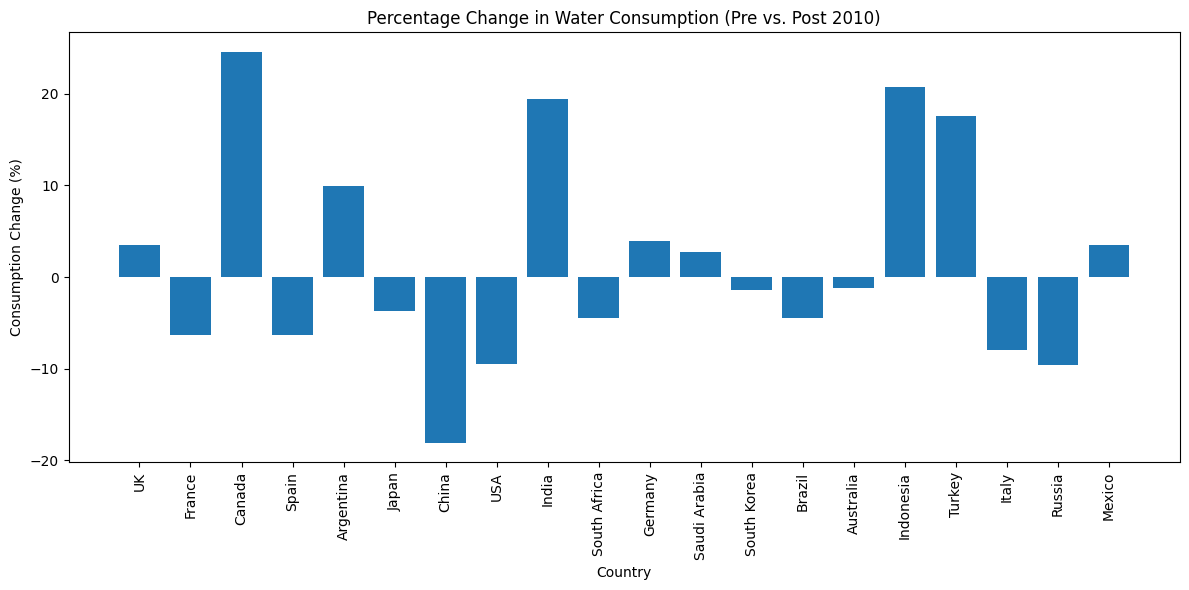

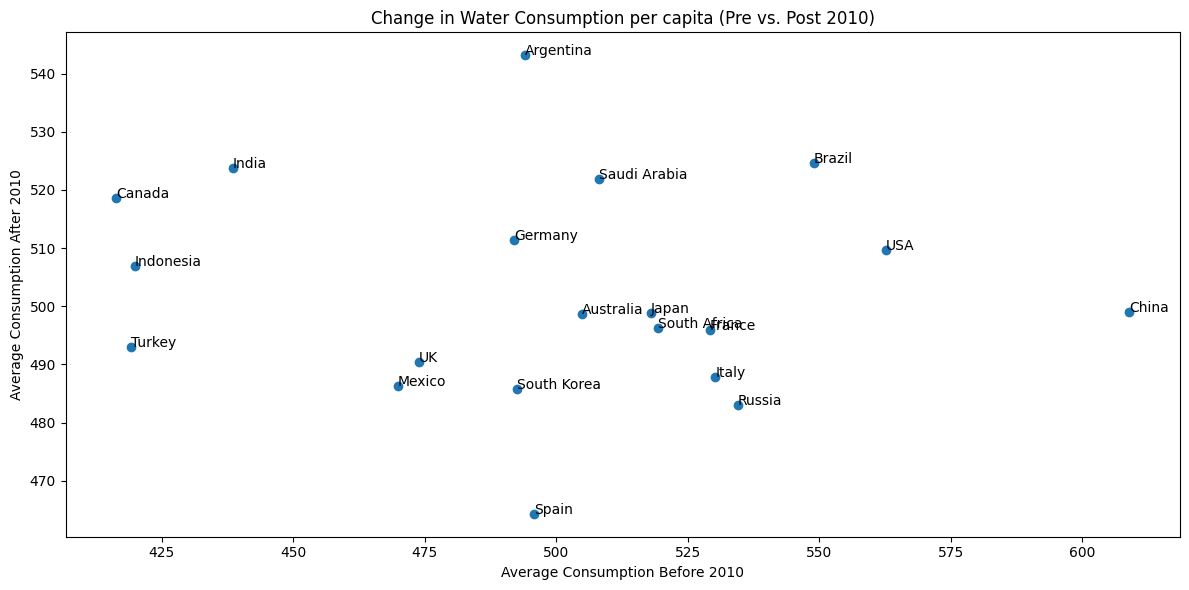

In [ ]:
# prompt: faire une visualisation a partir de country_improvements_results

import matplotlib.pyplot as plt

# Assuming country_improvements_results is a Spark DataFrame
# Convert it to a Pandas DataFrame for plotting
country_improvements_pandas = country_improvements_results.toPandas()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(country_improvements_pandas['Country'], country_improvements_pandas['ConsumptionChangePercent'])
plt.xlabel("Country")
plt.ylabel("Consumption Change (%)")
plt.title("Percentage Change in Water Consumption (Pre vs. Post 2010)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(country_improvements_pandas['AvgConsumptionPre'], country_improvements_pandas['AvgConsumptionPost'])
plt.xlabel("Average Consumption Before 2010")
plt.ylabel("Average Consumption After 2010")
plt.title("Change in Water Consumption per capita (Pre vs. Post 2010)")

for i, row in country_improvements_pandas.iterrows():
    plt.annotate(row['Country'], (row['AvgConsumptionPre'], row['AvgConsumptionPost']))

plt.tight_layout()
plt.show()


In [ ]:
# Fonction pour convertir un DataFrame Spark en pandas pour visualisation
def visualize_spark_df(spark_df, title, x_col, y_col, kind='bar'):
    pandas_df = spark_df.toPandas()
    plt.figure(figsize=(12, 6))
    if kind == 'bar':
        pandas_df.plot(kind=kind, x=x_col, y=y_col)
    elif kind == 'line':
        pandas_df.plot(kind=kind, x=x_col, y=y_col, marker='o')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")

In [ ]:
development_df = development_comparison_results.toPandas()
stability_df = stability_results.toPandas()
peaks_df = consumption_peaks_results.toPandas()


In [ ]:
print("Génération des visualisations...")

# Configuration globale pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
colors = plt.cm.tab10.colors

Génération des visualisations...


Visualisation 1 générée : Comparaison pays développés vs en développement


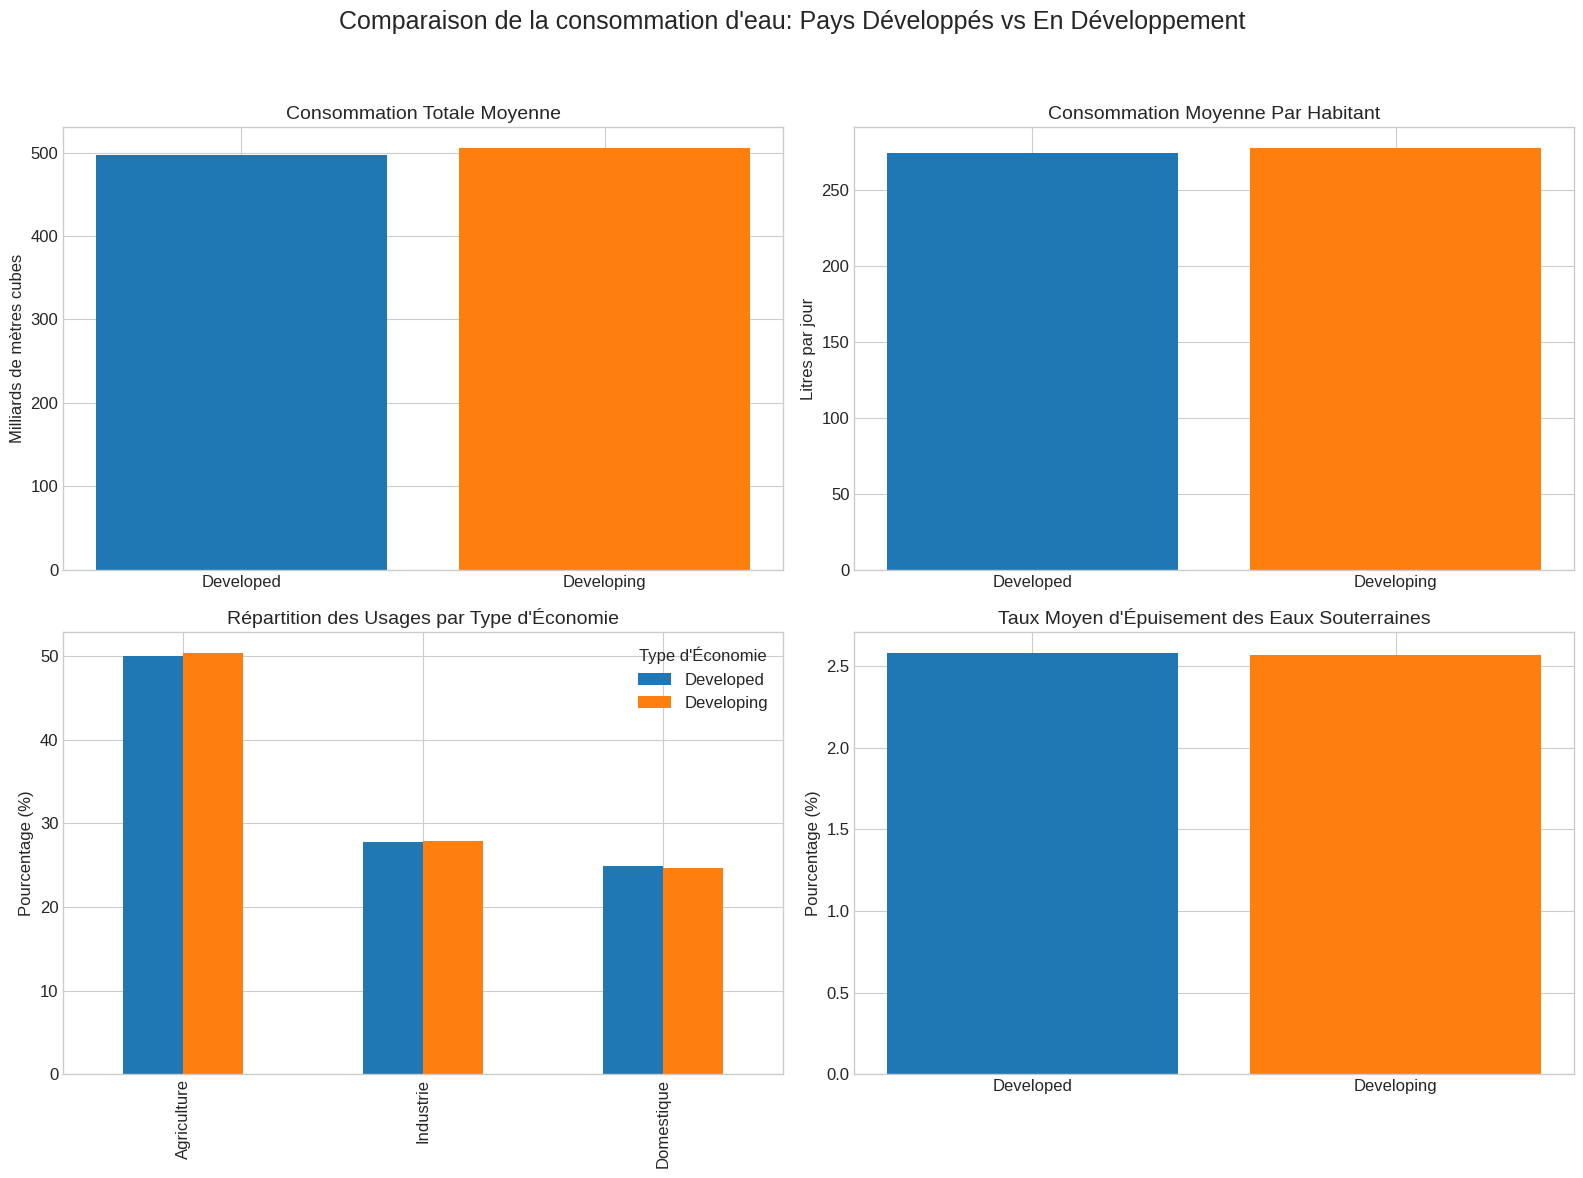

In [ ]:
# -------------------------------------------------------------------------
# Visualisation 1: Graphique en barres comparant pays développés et en développement
# -------------------------------------------------------------------------

# Calculer les moyennes par statut de développement
dev_status_means = development_df.groupby('DevelopmentStatus').mean()
dev_status_std = development_df.groupby('DevelopmentStatus').std()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison de la consommation d\'eau: Pays Développés vs En Développement', fontsize=18)

# Total Consumption
axes[0, 0].bar(dev_status_means.index, dev_status_means['AvgTotalConsumption'],
              yerr=dev_status_std['AvgTotalConsumption'], capsize=10,
              color=[colors[0], colors[1]])
axes[0, 0].set_title('Consommation Totale Moyenne', fontsize=14)
axes[0, 0].set_ylabel('Milliards de mètres cubes')

# Per Capita Consumption
axes[0, 1].bar(dev_status_means.index, dev_status_means['AvgPerCapitaConsumption'],
              yerr=dev_status_std['AvgPerCapitaConsumption'], capsize=10,
              color=[colors[0], colors[1]])
axes[0, 1].set_title('Consommation Moyenne Par Habitant', fontsize=14)
axes[0, 1].set_ylabel('Litres par jour')

# Usage breakdown
usage_data = dev_status_means[['AvgAgriculturalUse', 'AvgIndustrialUse', 'AvgHouseholdUse']]
usage_data = usage_data.rename(columns={
    'AvgAgriculturalUse': 'Agriculture',
    'AvgIndustrialUse': 'Industrie',
    'AvgHouseholdUse': 'Domestique'
})

usage_data.transpose().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Répartition des Usages par Type d\'Économie', fontsize=14)
axes[1, 0].set_ylabel('Pourcentage (%)')
axes[1, 0].set_xlabel('')
axes[1, 0].legend(title='Type d\'Économie')

# Depletion Rate
axes[1, 1].bar(dev_status_means.index, dev_status_means['AvgDepletionRate'],
              yerr=dev_status_std['AvgDepletionRate'], capsize=10,
              color=[colors[0], colors[1]])
axes[1, 1].set_title('Taux Moyen d\'Épuisement des Eaux Souterraines', fontsize=14)
axes[1, 1].set_ylabel('Pourcentage (%)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('comparison_developed_developing.png', dpi=300, bbox_inches='tight')

print("Visualisation 1 générée : Comparaison pays développés vs en développement")

<Figure size 1200x600 with 0 Axes>

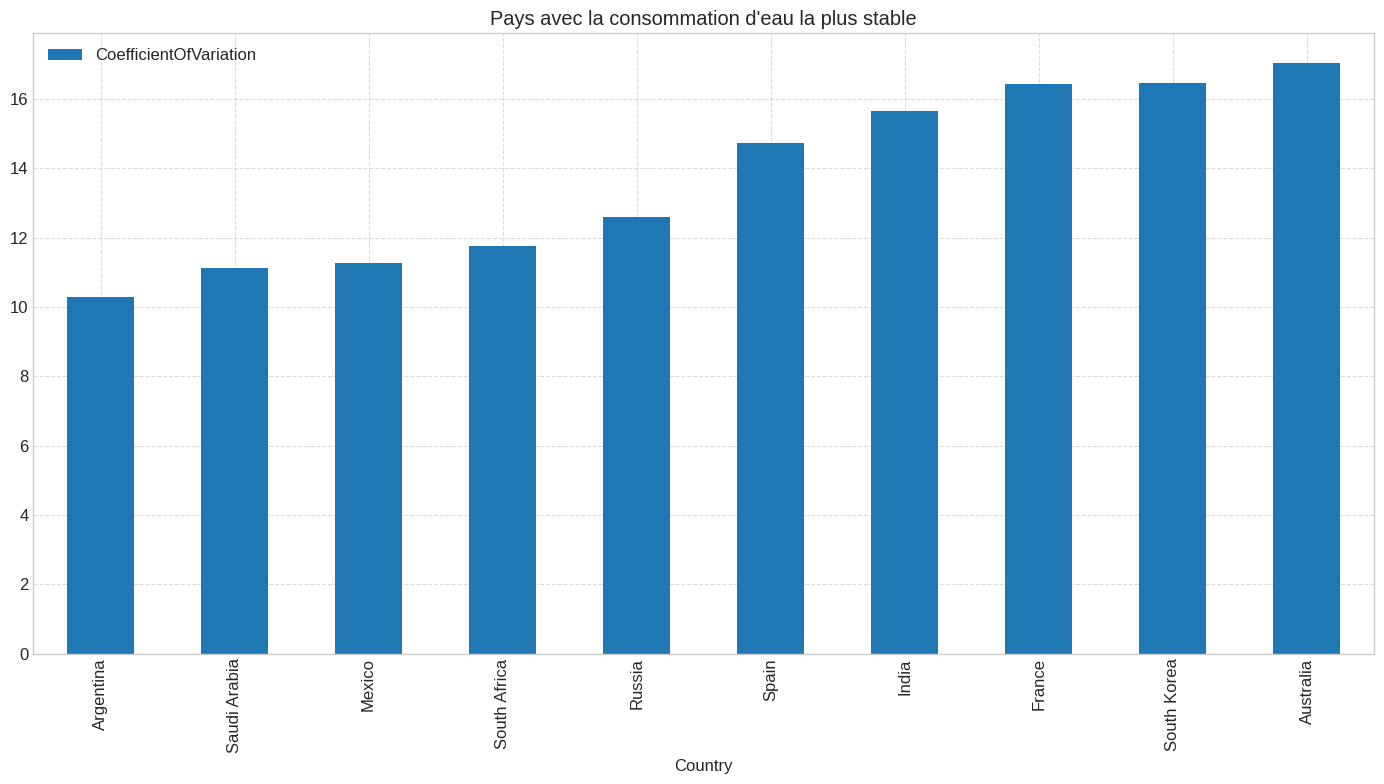

In [ ]:
# 1. Pays avec consommation d'eau la plus stable
try:
    visualize_spark_df(stability_results.limit(10),
                     "Pays avec la consommation d'eau la plus stable",
                     "Country", "CoefficientOfVariation")
except Exception as e:
    print(f"Impossible de créer la visualisation: {e}")

<Figure size 1200x600 with 0 Axes>

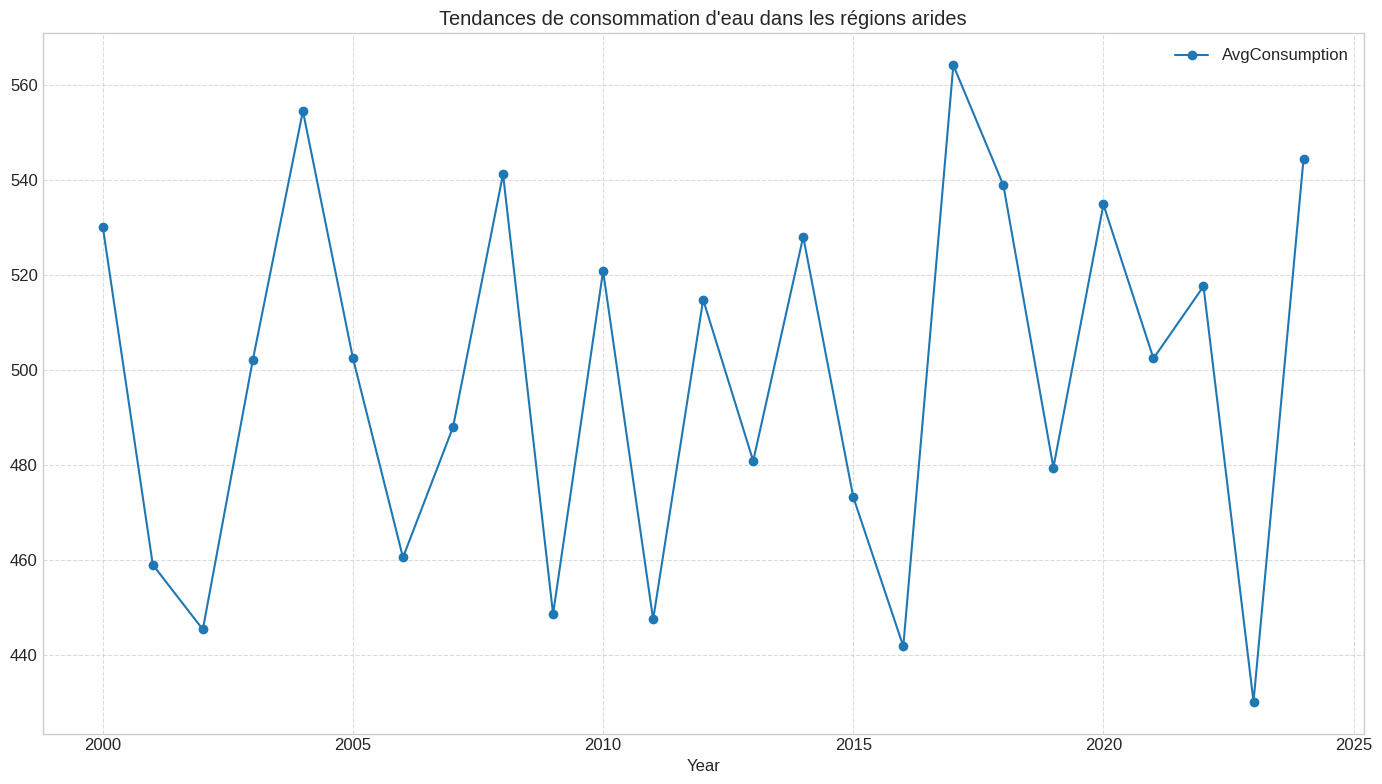

In [ ]:
# 2. Tendances des régions arides
try:
    arid_countries = arid_regions_results.select("Country").rdd.flatMap(lambda x: x).collect()
    arid_data = df_water.filter(col("Country").isin(arid_countries[:5]))
    arid_yearly_avg = arid_data.groupBy("Year").agg(avg("TotalConsumption").alias("AvgConsumption"))
    visualize_spark_df(arid_yearly_avg.orderBy("Year"),
                     "Tendances de consommation d'eau dans les régions arides",
                     "Year", "AvgConsumption", kind='line')
except Exception as e:
    print(f"Impossible de créer la visualisation: {e}")

<Figure size 1200x600 with 0 Axes>

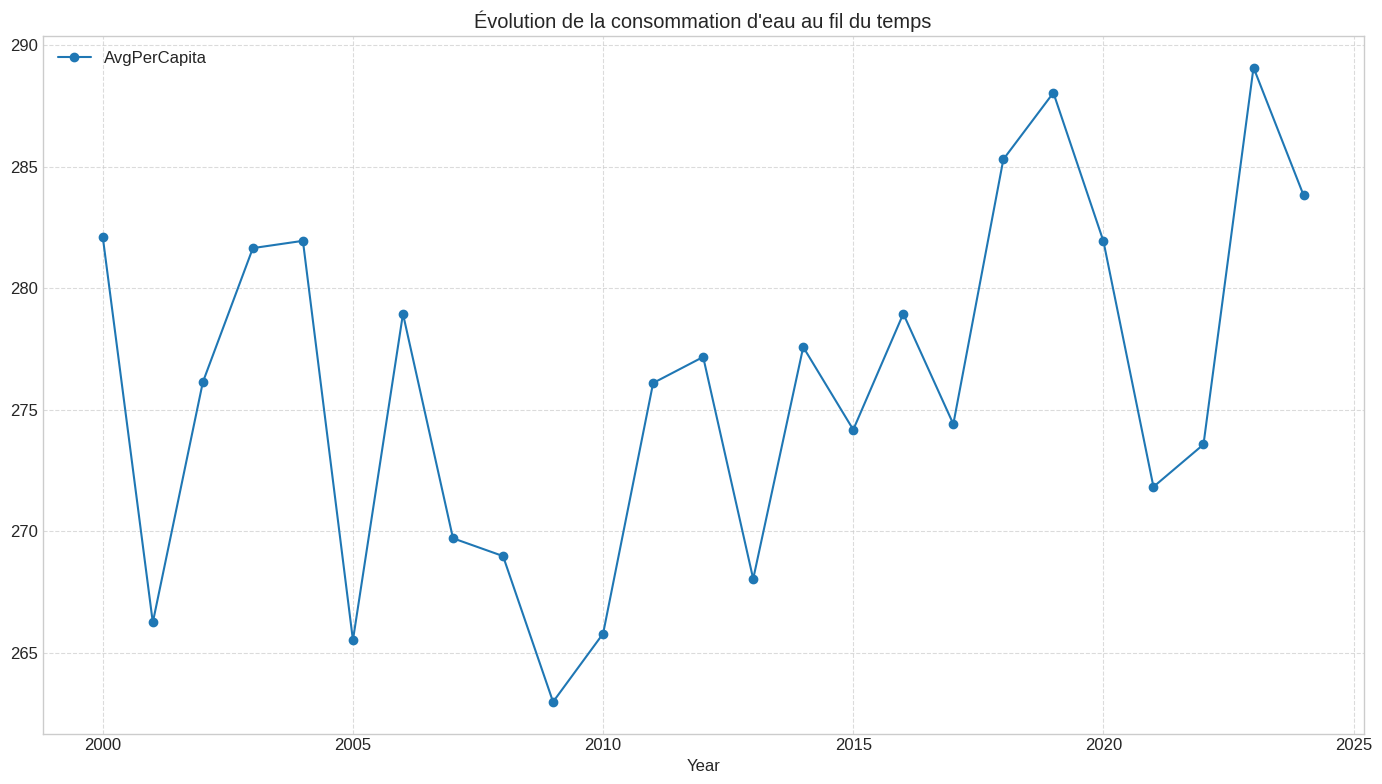

In [ ]:
# 3. Impact des politiques de conservation
try:
    yearly_trends = conservation_trends_results.orderBy("Year")
    visualize_spark_df(yearly_trends,
                     "Évolution de la consommation d'eau au fil du temps",
                     "Year", "AvgPerCapita", kind='line')
except Exception as e:
    print(f"Impossible de créer la visualisation: {e}")

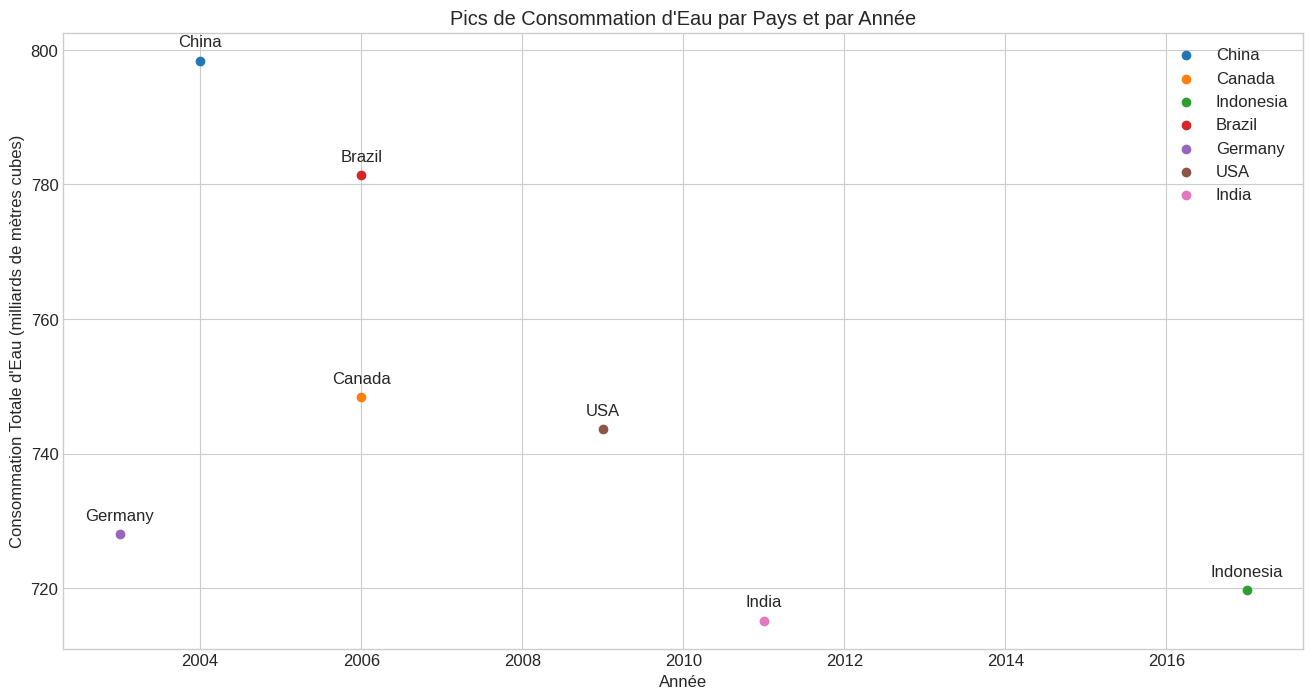

In [ ]:
# -------------------------------------------------------------------------
# Visualisation 3: Tendances temporelles et pics de consommation par région
# -------------------------------------------------------------------------
plt.figure(figsize=(16, 8))

# Create the scatter plot
for country in peaks_df['Country'].unique():
    country_data = peaks_df[peaks_df['Country'] == country]
    plt.scatter(country_data['Year'], country_data['TotalConsumption'], label=country)

# Add labels and title
plt.xlabel("Année")
plt.ylabel("Consommation Totale d'Eau (milliards de mètres cubes)")
plt.title("Pics de Consommation d'Eau par Pays et par Année")

# Add country names as annotations
for i, row in peaks_df.iterrows():
  plt.annotate(row['Country'], (row['Year'], row['TotalConsumption']), textcoords="offset points", xytext=(0,10), ha='center')


plt.legend()  # Show the legend with country names
plt.grid(True)
plt.show()


In [ ]:
df_water.show()

+---------+----+----------------+--------------------+----------------------+--------------------+-------------------+---------+-------------+
|  Country|Year|TotalConsumption|PerCapitaConsumption|AgriculturalUsePercent|IndustrialUsePercent|HouseholdUsePercent| Rainfall|DepletionRate|
+---------+----+----------------+--------------------+----------------------+--------------------+-------------------+---------+-------------+
|Argentina|2000|          481.49|           235.43143|                 48.55|           20.844286|               30.1|1288.6986|    3.2557142|
|Argentina|2001|         455.063|             299.551|                48.465|              26.943|              22.55| 1371.729|         3.12|
|Argentina|2002|       482.74924|            340.1246|             50.375385|           29.042307|          23.349232|1590.3054|    2.7338462|
|Argentina|2003|          452.66|           326.75665|             49.086666|              30.476|              24.44|1816.0127|        2.708|

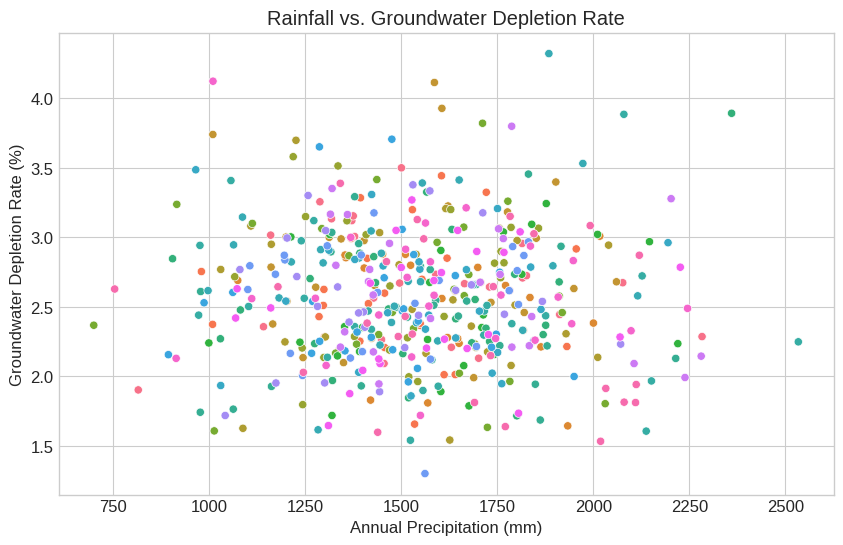

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rainfall',
                y='DepletionRate',
                hue='Country',
                data=df_water.toPandas(), legend=False)  # Convert to Pandas DataFrame
plt.title('Rainfall vs. Groundwater Depletion Rate')
plt.xlabel('Annual Precipitation (mm)')
plt.ylabel('Groundwater Depletion Rate (%)')
plt.show()